# Final Project - ST590

## Building an Expected Goals Model With NHL Shots Data
#### Josh Baber and Rich Ramsey

The practice and application of analytics and statistical modeling in the NHL has advanced a great deal in the last 10 years. As two hockey fans, we naturally wanted to get our hands on some of the data available and try out building our own model utilizing those data.

The data set comes from [Money Puck](https://www.moneypuck.com/), a website that produces many different statistical models and NHL advanced statistics available for the public. It contains all the shots that were taken in NHL games in the 2021-22 season. The data were collected from several different sources, including the NHL and ESPN, per Money Puck. There are many variables that are calculated on top of the raw variables from those sources, which were calculated by Money Puck for the purposes of fitting different models.  Expected goals models are used to evaluate the quality of shots that a team is generating, as well as how likely a team is to win a game based on the quality of shots taken.

Our goal with these data is to build a logistic regression model, a classification tree, and a random forest model to predict the likelihood a goal is scored on a given shot. We will take into account many different factors in the data, such as the shot distance from the goal, the shot angle (straight on from the goal would be 0), the type of shot, whether the team was on the power play, penalty kill, or at even strength, and many more possible predictors from the data set. It will require us to investigate the data set in the exploratory analysis part and try to create features out of the numerous variables included in the data set.

The data set can be downloaded from [this link.](https://www.moneypuck.com/data.htm)  It's the "2021-2022 Season (121,471 shots)" data set at the very bottom of the webpage.

## Setup and Reading Data Files

To start, we need to import some libraries that will be used for data processing and plotting.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps

Next, we will start up a `pyspark` instance using `SparkSession`.

In [2]:
# Additional code to ensure that this will run on Windows
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Set up spark instance
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

With the Spark instance up and running, we'll need to import the data from the .csv file using `.read_csv()`. We'll take a look at the top 5 rows in the data set using `.head()` just to get a sense for what we're dealing with.

In [3]:
# read in data from csv file
nhl_shots = pd.read_csv("Data/shots_2021.csv")
nhl_shots.head(5)

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,42.520583,61.0,61.0,-32.0,32.0,-8.4,0,0,0,...,61,0.202514,0.009192,0.445979,0.289830,0.023891,0.028594,0.718082,-32,-32
1,1,30.610456,-65.0,65.0,19.0,19.0,21.4,0,0,0,...,65,0.285948,0.031353,0.303080,0.325607,0.026384,0.027629,0.793188,19,-19
2,2,85.381497,-8.0,8.0,-27.0,27.0,3.8,0,0,0,...,8,0.161225,0.012753,0.307661,0.486296,0.019218,0.012846,0.840122,-27,27
3,3,29.274562,-60.0,60.0,-4.0,4.0,0.0,0,0,0,...,60,0.161623,0.121753,0.374061,0.264891,0.024508,0.053163,0.729294,-4,4
4,4,26.305893,63.0,63.0,4.0,4.0,0.0,0,0,0,...,63,0.116379,0.088392,0.432747,0.284554,0.018850,0.059078,0.695010,4,4


Some of the columns will need to be removed because they are the results of MoneyPuck's models (xGoal, xFroze, etc. are the "expected" variables showing probabilities of those outcomes from the MoneyPuck model). Others have a strong relationship with the goal variable or provide some post-shot information, which can't be included in predicting the probability of a goal (timeUntilNextEvent, shotPlayContinued, etc. indicate the shot was not scored). Finally, some are not relevant to predicting the likelihood of a goal being scored on the shot (ex: shot ID, game ID). Perhaps those could be included if we wanted to look at the predicted goal probability for a given shot or the number of goals "expected" to be scored in a game, on average.  We made a list of these columns then dropped them from our data set using the `.drop()` method.

In [4]:
# List of columns to exclude
columns_to_exclude = ['shotID', 'season', 'game_id', 'homeTeamWon', 'timeUntilNextEvent', 'event', 
                      'shotPlayContinuedOutsideZone', 'shotPlayContinuedInZone', 'shotGoalieFroze', 'shotPlayStopped','shotGeneratedRebound', 
                      'playerPositionThatDidEvent', 'playerNumThatDidEvent', 'playerNumThatDidLastEvent',
                      'location', 'xGoal', 'xFroze', 'xRebound', 'xPlayContinuedInZone', 'xPlayContinuedOutsideZone', 'xPlayStopped', 'xShotWasOnGoal',
                      'shotWasOnGoal']

# drop columns from shots data frame
nhl_shots = nhl_shots.drop(columns_to_exclude, axis = 1)

Now that the pandas data frame has the necessary columns removed and is in good shape for analysis and modeling, we will convert it to a spark data frame. To ensure the data are read into the spark data frame properly, we specified a schema with the data types for each variable in the data set.  This schema will detail the data type for each variable in the data set.  We can do this using the `StructType()` and `StructField()` functions from PySpark.

In [5]:
# import Spark sql data types functions
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Specify data types for each variable, set third argument to True to ensure they are not NULL
nhl_schema = StructType([
    StructField("arenaAdjustedShotDistance", FloatType(), True),
    StructField("arenaAdjustedXCord", FloatType(), True),
    StructField("arenaAdjustedXCordABS", FloatType(), True),
    StructField("arenaAdjustedYCord", FloatType(), True),
    StructField("arenaAdjustedYCordAbs", FloatType(), True),
    StructField("averageRestDifference", FloatType(), True),
    StructField("awayEmptyNet", IntegerType(), True),
    StructField("awayPenalty1TimeLeft", IntegerType(), True),
    StructField("awayPenalty1Length", IntegerType(), True),
    StructField("awaySkatersOnIce", IntegerType(), True),
    StructField("awayTeamCode", StringType(), True),
    StructField("awayTeamGoals", IntegerType(), True),
    StructField("defendingTeamAverageTimeOnIce", FloatType(), True),
    StructField("defendingTeamAverageTimeOnIceOfDefencemen", FloatType(), True),
    StructField("defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff", FloatType(), True),
    StructField("defendingTeamAverageTimeOnIceOfForwards", FloatType(), True),
    StructField("defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff", FloatType(), True),
    StructField("defendingTeamAverageTimeOnIceSinceFaceoff", FloatType(), True),
    StructField("defendingTeamDefencemenOnIce", IntegerType(), True),
    StructField("defendingTeamForwardsOnIce", IntegerType(), True),
    StructField("defendingTeamMaxTimeOnIce", IntegerType(), True),
    StructField("defendingTeamMaxTimeOnIceOfDefencemen", IntegerType(), True),
    StructField("defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff", IntegerType(), True),
    StructField("defendingTeamMaxTimeOnIceOfForwards", IntegerType(), True),
    StructField("defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff", IntegerType(), True),
    StructField("defendingTeamMaxTimeOnIceSinceFaceoff", IntegerType(), True),
    StructField("defendingTeamMinTimeOnIce", IntegerType(), True),
    StructField("defendingTeamMinTimeOnIceOfDefencemen", IntegerType(), True),
    StructField("defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff", IntegerType(), True),
    StructField("defendingTeamMinTimeOnIceOfForwards", IntegerType(), True),
    StructField("defendingTeamMinTimeOnIceOfForwardsSinceFaceoff", IntegerType(), True),
    StructField("defendingTeamMinTimeOnIceSinceFaceoff", IntegerType(), True),
    StructField("distanceFromLastEvent", FloatType(), True),
    StructField("goal", IntegerType(), True),
    StructField("goalieIDForShot", IntegerType(), True),
    StructField("goalieNameForShot", StringType(), True),
    StructField("homeEmptyNet", IntegerType(), True),
    StructField("homePenalty1TimeLeft", IntegerType(), True),
    StructField("homePenalty1Length", IntegerType(), True),
    StructField("homeSkatersOnIce", IntegerType(), True),
    StructField("homeTeamCode", StringType(), True),
    StructField("homeTeamGoals", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("isPlayoffGame", FloatType(), True),
    StructField("isHomeTeam", IntegerType(), True),
    StructField("lastEventCategory", StringType(), True),
    StructField("lastEventShotAngle", FloatType(), True),
    StructField("lastEventShotDistance", FloatType(), True),
    StructField("lastEventTeam", StringType(), True),
    StructField("lastEventxCord", IntegerType(), True),
    StructField("lastEventxCord_adjusted", IntegerType(), True),
    StructField("lastEventyCord", IntegerType(), True),
    StructField("lastEventyCord_adjusted", IntegerType(), True),
    StructField("offWing", IntegerType(), True),
    StructField("period", IntegerType(), True),
    StructField("shooterLeftRight", StringType(), True),
    StructField("shooterName", StringType(), True),
    StructField("shooterPlayerID", FloatType(), True),
    StructField("shooterTimeOnIce", IntegerType(), True),
    StructField("shooterTimeOnIceSinceFaceoff", IntegerType(), True),
    StructField("shootingTeamAverageTimeOnIce", FloatType(), True),
    StructField("shootingTeamAverageTimeOnIceOfDefencemen", FloatType(), True),
    StructField("shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff", FloatType(), True),
    StructField("shootingTeamAverageTimeOnIceOfForwards", FloatType(), True),
    StructField("shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff", FloatType(), True),
    StructField("shootingTeamAverageTimeOnIceSinceFaceoff", FloatType(), True),
    StructField("shootingTeamDefencemenOnIce", IntegerType(), True),
    StructField("shootingTeamForwardsOnIce", IntegerType(), True),
    StructField("shootingTeamMaxTimeOnIce", IntegerType(), True),
    StructField("shootingTeamMaxTimeOnIceOfDefencemen", IntegerType(), True),
    StructField("shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff", IntegerType(), True),
    StructField("shootingTeamMaxTimeOnIceOfForwards", IntegerType(), True),
    StructField("shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff", IntegerType(), True),
    StructField("shootingTeamMaxTimeOnIceSinceFaceoff", IntegerType(), True),
    StructField("shootingTeamMinTimeOnIce", IntegerType(), True),
    StructField("shootingTeamMinTimeOnIceOfDefencemen", IntegerType(), True),
    StructField("shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff", IntegerType(), True),
    StructField("shootingTeamMinTimeOnIceOfForwards", IntegerType(), True),
    StructField("shootingTeamMinTimeOnIceOfForwardsSinceFaceoff", IntegerType(), True),
    StructField("shootingTeamMinTimeOnIceSinceFaceoff", IntegerType(), True),
    StructField("shotAngle", FloatType(), True),
    StructField("shotAngleAdjusted", FloatType(), True),
    StructField("shotAnglePlusRebound", FloatType(), True),
    StructField("shotAnglePlusReboundSpeed", FloatType(), True),
    StructField("shotAngleReboundRoyalRoad", IntegerType(), True),
    StructField("shotDistance", FloatType(), True),
    StructField("shotOnEmptyNet", IntegerType(), True),
    StructField("shotRebound", IntegerType(), True),
    StructField("shotRush", IntegerType(), True),
    StructField("shotType", StringType(), True),
    StructField("speedFromLastEvent", FloatType(), True),
    StructField("team", StringType(), True),
    StructField("teamCode", StringType(), True),
    StructField("time", IntegerType(), True),
    StructField("timeDifferenceSinceChange", IntegerType(), True),
    StructField("timeSinceFaceoff", IntegerType(), True),
    StructField("timeSinceLastEvent", IntegerType(), True),
    StructField("xCord", IntegerType(), True),
    StructField("xCordAdjusted", IntegerType(), True),
    StructField("yCord", IntegerType(), True),
    StructField("yCordAdjusted", IntegerType(), True)
])

Now that we have the schema made, we can use `spark.createDataFrame()` to create a Spark DataFrame from the pandas data frame.

In [6]:
# create a spark DataFrame using the aforementioned schema
nhl_spark = spark.createDataFrame(nhl_shots, schema = nhl_schema)
# Check to see that it is a pyspark DataFrame
type(nhl_spark)

pyspark.sql.dataframe.DataFrame

## Supervised Learning and the Training and Test Split

It is important to split our data set into training and holdout (test) sets. If we train the models on 100% of the data set, there is a greater risk of overfitting. Evaluating different model fits on data that the models were not trained on gives a much more independent evaluation. The test set is generally 20% to 30% of the data set, with the rest going into the training set.  We can split the data using the `.randomSplit()` method.

In [7]:
# split data into train and test groups
train_proportion = 0.75

train, test = nhl_spark.randomSplit([train_proportion, (1 - train_proportion)], seed = 19)
print(train.count(), test.count())

91014 30457


We'll have roughly 91,000 observations in our training set and 30,000 in the test set.

A supervised learning problem requires that we supply a response variable, which is the outcome(s) we are trying to predict, and a set of predictor variables to predict those outcomes. The models we fit will attempt to optimize the predictiveness of the model based on the loss function we choose, which in this case will be the AUROC, or the area under the ROC curve.  This measures the true positive rate against the false positive rate, and the area under that curve is the value of this measurement.  For context, it essentially measures the proportion of correctly predicted goals against the proportion of incorrectly predicted goals.  We will be trying to get models that have the highest AUC possible.  A completely random classifier would have an AUC of 0.5.  This is a widely accepted and common method for evaluating binary classification models.

We also need to cross-validate our models when fitting them.  Cross validation is particularly useful when choosing values for certain tuning parameters that determine how the models are fit.  For example, there are different tuning parameters to consider for a random forest model. One of those is m, which represents the number of variables to randomly subset to for each generated tree. Another is the maximum depth of trees fit to make up the random forest model. Cross validation gives us the option to choose a few different values of those parameters to try, and will tell us the overall performance on the training set for each model with different values of those parameters. This is important because we usually will not know which values to set for those parameters. The cross validation algorithm uses a subset of the training data to train the model on, then uses the remainder as held-out data.  It evaluates that model on the held-out data then moves on to the next subset of data and repeats the process.  It repeats this process k times (or folds), which is specified by the user in the function call.

## Exploratory Data Analysis

First, we need to import some functions from the spark ML libraries. Statistics, KernelDensity and Correlation are for part of the exploratory analysis. SQLTransformer, VectorAssembler, and Interaction are for creating new features. Finally, the Pipeline is for bringing together all of these components into a defined set of actions in our Spark model fitting pipelines.

In [8]:
# Import functions
from pyspark.mllib.stat import Statistics
from pyspark.mllib.stat import KernelDensity
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import SQLTransformer, VectorAssembler, Interaction, PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

We also need to set up the plotting back end library for pyspark. There are two options, `plotly` and `matplotlib`, for this plotting. We'll opt for `matplotlib` for now.

In [9]:
# setting up the back end plotting library for pyspark
ps.options.plotting.backend = 'matplotlib'

We can look at the total shots on empty net goals using the `.groupBy()` and `.agg()` functions.  We can also find the percent of goals that were scored on empty net and non-empty net goals.  We can find the mean and standard deviations of shot distance and shot angle for each as well.

In [10]:
# Group by shotOnEmptyNet, find the count, mean, and standard deviation of shot distance and angle for each group as well as scoring percentages
train.groupBy("shotOnEmptyNet") \
.agg(F.count("id").alias("shots"), \
     F.round(F.mean("goal"), 4).alias("scoredPercentage"), \
     F.round(F.mean("shotDistance"), 2).alias("shotDistanceMean"), \
     F.round(F.stddev("shotDistance"), 2).alias("shotDistanceStdDev"), \
     F.round(F.mean("shotAngleAdjusted"), 2).alias("shotAngleMean"), \
    F.round(F.stddev("shotAngleAdjusted"), 2).alias("shotAngleStdDev")) \
.sort(F.col("shotOnEmptyNet")) \
.show(truncate = False)

+--------------+-----+----------------+----------------+------------------+-------------+---------------+
|shotOnEmptyNet|shots|scoredPercentage|shotDistanceMean|shotDistanceStdDev|shotAngleMean|shotAngleStdDev|
+--------------+-----+----------------+----------------+------------------+-------------+---------------+
|0             |90420|0.0683          |33.43           |18.46             |30.53        |20.57          |
|1             |594  |0.6364          |45.52           |25.91             |26.04        |21.83          |
+--------------+-----+----------------+----------------+------------------+-------------+---------------+



There are only 594 shots on empty nets in this training set, but they are scored 64% of the time! Intuitively, shooting on an empty net (when the opposing goalie has been taken off the ice) is much easier and typically happens only when the team shooting on the empty net is leading late in the game. We believe that removing those empty net shots from the data before model fitting would be a good idea given how drastic the difference is between shot conversion on those and non-empty net shots.  We will need to do this for both the training and testing set, as with all transformations of the data.

In [11]:
# Remove the empty net shots from both the training and testing sets
train = train.where(F.col("shotOnEmptyNet") == 0)
test = test.where(F.col("shotOnEmptyNet") == 0)
# Display new count of training data
train.count()

90420

With the empty net shots removed, let's continue with the analysis to see which variables might be good predictors of whether a goal is scored on the shot.

We can look at the scoring percentage for each type of shot.  There are seven different shot types, we can find the average shot distance and angle for each type of shot as well as the standard deviations for each of those.  Once again we are using `.groupBy()` to group these shot types and `.agg()` to find the means, standard deviations, counts, and scoring percentages here.

In [12]:
# Produce summary statistics for each shot type
train.groupBy("shotType") \
.agg(F.count("id").alias("shots"), \
     F.round(F.mean("goal"), 3).alias("scoredPercentage"), \
     F.round(F.mean("shotDistance"), 2).alias("shotDistanceMean"), \
     F.round(F.stddev("shotDistance"), 2).alias("shotDistanceStdDev"), \
     F.round(F.mean("shotAngleAdjusted"), 2).alias("shotAngleMean"), \
    F.round(F.stddev("shotAngleAdjusted"), 2).alias("shotAngleStdDev")) \
.sort(F.col("shotType")) \
.show(truncate = False)

+--------+-----+----------------+----------------+------------------+-------------+---------------+
|shotType|shots|scoredPercentage|shotDistanceMean|shotDistanceStdDev|shotAngleMean|shotAngleStdDev|
+--------+-----+----------------+----------------+------------------+-------------+---------------+
|BACK    |6648 |0.088           |18.5            |14.64             |35.88        |24.25          |
|DEFL    |2319 |0.092           |19.08           |15.98             |19.87        |17.89          |
|NaN     |3    |0.667           |7.84            |2.49              |36.12        |25.83          |
|SLAP    |12301|0.05            |47.48           |12.93             |26.33        |15.89          |
|SNAP    |11567|0.086           |35.22           |15.19             |30.81        |19.16          |
|TIP     |6296 |0.096           |16.72           |13.21             |19.25        |16.77          |
|WRAP    |737  |0.041           |8.29            |6.27              |59.65        |19.2           |


There are plenty of useful observations from this summary of different shot types. In this summary, we excluded any empty net shots given those are a very small percentage of the sample and are scored at a much higher rate. We are looking at the number of shot attempts, percent of those attempts that were goals (scoredPercentage), mean and standard deviation of shot distance, and the mean and standard deviation of shot angle.
- Deflections and tipped shots are scored at high rates and on average, are taken at angles closer in to 0 than other types of shots.
- Slap shots are taken from the furthest average distance and are scored at a relatively low rate.
- Snap shots, which are sort of somewhere in between a wrist shot and a slap shot in technique, are scored at a high rate.
- Wraparound shots are taken, on average, much closer to the opposing goal and at a wider angle, on average. They are converted to goals at a low rate.
- Wrist shots make up the vast majority of the shot attempts. This could be the reference category in a logistic regression model.

We'd like to create some indicator (dummy) variables for the different shot types so those can be used in fitting models using the `.withColumns()` method.  Again, we need to repeat this process for the testing set as well.

In [13]:
# create shot type dummy variables
train = train.withColumn("shotType_Backhand", F.when((train.shotType == "BACK"), 1).otherwise(0))
train = train.withColumn("shotType_Deflection", F.when((train.shotType == "DEFL"), 1).otherwise(0))
train = train.withColumn("shotType_Slap", F.when((train.shotType == "SLAP"), 1).otherwise(0))
train = train.withColumn("shotType_Snap", F.when((train.shotType == "SNAP"), 1).otherwise(0))
train = train.withColumn("shotType_Tip", F.when((train.shotType == "TIP"), 1).otherwise(0))
train = train.withColumn("shotType_Wrap", F.when((train.shotType == "WRAP"), 1).otherwise(0))
train = train.withColumn("shotType_Wrist", F.when((train.shotType == "WRIST"), 1).otherwise(0))

test = test.withColumn("shotType_Backhand", F.when((test.shotType == "BACK"), 1).otherwise(0))
test = test.withColumn("shotType_Deflection", F.when((test.shotType == "DEFL"), 1).otherwise(0))
test = test.withColumn("shotType_Slap", F.when((test.shotType == "SLAP"), 1).otherwise(0))
test = test.withColumn("shotType_Snap", F.when((test.shotType == "SNAP"), 1).otherwise(0))
test = test.withColumn("shotType_Tip", F.when((test.shotType == "TIP"), 1).otherwise(0))
test = test.withColumn("shotType_Wrap", F.when((test.shotType == "WRAP"), 1).otherwise(0))
test = test.withColumn("shotType_Wrist", F.when((test.shotType == "WRIST"), 1).otherwise(0))

# look at some records for the new indicator variables for different shot types
train.select(["shotType", "shotType_Backhand", "shotType_Deflection", "shotType_Slap",
                 "shotType_Snap", "shotType_Tip", "shotType_Wrap", "shotType_Wrist"]).show(20)

+--------+-----------------+-------------------+-------------+-------------+------------+-------------+--------------+
|shotType|shotType_Backhand|shotType_Deflection|shotType_Slap|shotType_Snap|shotType_Tip|shotType_Wrap|shotType_Wrist|
+--------+-----------------+-------------------+-------------+-------------+------------+-------------+--------------+
|    DEFL|                0|                  1|            0|            0|           0|            0|             0|
|   WRIST|                0|                  0|            0|            0|           0|            0|             1|
|   WRIST|                0|                  0|            0|            0|           0|            0|             1|
|   WRIST|                0|                  0|            0|            0|           0|            0|             1|
|    WRAP|                0|                  0|            0|            0|           0|            1|             0|
|   WRIST|                0|                  0|

Most of the shots are wrist shots, but above we can see some examples of the indicator variables that we created.

Next, we'd like to look at situations where the shooting team has more or fewer skaters on the ice than the defending team. This generally happens when a player or two take a penalty, however overtime periods are played at 3 on 3, and teams have the option to pull their goalies at any time for a 6th player. First, we need to look at the number of skaters on ice for each team and create variables for those. We already have the number of forwards and defencemen each team has on the ice, so adding those up gives us the number of skaters (goalies are not included).  We use the `.withColumn()` method here to create these new columns for the training and testing sets.

In [14]:
# Create new skatersOnIce columns for training and testing sets
train = train.withColumn("shootingTeamSkatersOnIce", train.shootingTeamDefencemenOnIce + train.shootingTeamForwardsOnIce)
train = train.withColumn("defendingTeamSkatersOnIce", train.defendingTeamDefencemenOnIce + train.defendingTeamForwardsOnIce)

test = test.withColumn("shootingTeamSkatersOnIce", test.shootingTeamDefencemenOnIce + test.shootingTeamForwardsOnIce)
test = test.withColumn("defendingTeamSkatersOnIce", test.defendingTeamDefencemenOnIce + test.defendingTeamForwardsOnIce)

In [15]:
# Find the counts, scored percentages, mean and sd of shot distances and shot angles for each combination of shooting and defending skaters on ice
train.groupBy("shootingTeamSkatersOnIce", "defendingTeamSkatersOnIce") \
.agg(F.count("id").alias("shots"), \
     F.round(F.mean("goal"), 3).alias("scoredPercentage"), \
     F.round(F.mean("shotDistance"), 2).alias("shotDistanceMean"), \
     F.round(F.stddev("shotDistance"), 2).alias("shotDistanceStdDev"), \
     F.round(F.mean("shotAngleAdjusted"), 2).alias("shotAngleMean"), \
    F.round(F.stddev("shotAngleAdjusted"), 2).alias("shotAngleStdDev")) \
.sort(F.col("shootingTeamSkatersOnIce"), F.col("defendingTeamSkatersOnIce")) \
.show(truncate = False)

+------------------------+-------------------------+-----+----------------+----------------+------------------+-------------+---------------+
|shootingTeamSkatersOnIce|defendingTeamSkatersOnIce|shots|scoredPercentage|shotDistanceMean|shotDistanceStdDev|shotAngleMean|shotAngleStdDev|
+------------------------+-------------------------+-----+----------------+----------------+------------------+-------------+---------------+
|3                       |3                        |979  |0.125           |24.49           |12.92             |27.17        |19.36          |
|3                       |4                        |23   |0.087           |30.22           |19.73             |35.08        |19.87          |
|3                       |5                        |22   |0.0             |36.28           |16.53             |30.26        |24.61          |
|4                       |2                        |1    |0.0             |28.84           |null              |33.69        |null           |
|4    

There may be some data recording errors in the instances with more than 6 skaters on ice, but there are only a few records with that issue. The instances where the defending team has only one skater on the ice may be a data error or the result of a line change gone horribly wrong, where the defending team got all its skaters off the ice at an inopportune time. Given there are only a few records with those issues, it shouldn't cause a problem for our modeling of a data set with roughly 120,000 records.
Our next step is to create indicator variables for when the shooting team is on the power play (more skaters on ice than the defending team), even strength (same number of skaters as the defending team), or the penalty kill (fewer skaters on ice than the defending team).

In [16]:
# create indicator variables on power play, even strength, and penalty kill game situations for train set
train = train.withColumn("powerPlay", F.when((train.shootingTeamSkatersOnIce > train.defendingTeamSkatersOnIce), 1).otherwise(0))
train = train.withColumn("evenStrength", F.when((train.shootingTeamSkatersOnIce == train.defendingTeamSkatersOnIce), 1).otherwise(0))
train = train.withColumn("penaltyKill", F.when((train.shootingTeamSkatersOnIce < train.defendingTeamSkatersOnIce), 1).otherwise(0))

# create indicator variables on power play, even strength, and penalty kill game situations for test set
test = test.withColumn("powerPlay", F.when((test.shootingTeamSkatersOnIce > test.defendingTeamSkatersOnIce), 1).otherwise(0))
test = test.withColumn("evenStrength", F.when((test.shootingTeamSkatersOnIce == test.defendingTeamSkatersOnIce), 1).otherwise(0))
test = test.withColumn("penaltyKill", F.when((test.shootingTeamSkatersOnIce < test.defendingTeamSkatersOnIce), 1).otherwise(0))

If we need to access the numeric columns in the dataframe, it will be nice to have those stored as a variable.

In [17]:
# list of the int or float type columns in the spark data frame
numeric_columns = [t[0] for t in train.dtypes if (t[1] == 'int' or t[1] == 'float')]
numeric_columns

['arenaAdjustedShotDistance',
 'arenaAdjustedXCord',
 'arenaAdjustedXCordABS',
 'arenaAdjustedYCord',
 'arenaAdjustedYCordAbs',
 'averageRestDifference',
 'awayEmptyNet',
 'awayPenalty1TimeLeft',
 'awayPenalty1Length',
 'awaySkatersOnIce',
 'awayTeamGoals',
 'defendingTeamAverageTimeOnIce',
 'defendingTeamAverageTimeOnIceOfDefencemen',
 'defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff',
 'defendingTeamAverageTimeOnIceOfForwards',
 'defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff',
 'defendingTeamAverageTimeOnIceSinceFaceoff',
 'defendingTeamDefencemenOnIce',
 'defendingTeamForwardsOnIce',
 'defendingTeamMaxTimeOnIce',
 'defendingTeamMaxTimeOnIceOfDefencemen',
 'defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff',
 'defendingTeamMaxTimeOnIceOfForwards',
 'defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff',
 'defendingTeamMaxTimeOnIceSinceFaceoff',
 'defendingTeamMinTimeOnIce',
 'defendingTeamMinTimeOnIceOfDefencemen',
 'defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff',
 'defend

With so many different variables to consider including as predictors, we'd like to look at the correlation between some of those variables. If we include multiple predictors with strong correlations between each other, that can lead to issues with the estimates of coefficients for those variables in a logistic regression model or cause problems for fitting tree-based models with those correlated predictors included. We created a function to calculate a correlation matrix for a specified set of numeric predictors in a specified data frame (we'll be using our nhl data in spark, obviously). This function will return a data frame of the correlation between variables with properly labeled columns and rows (using indices). The number in each cell will be the correlation between the variable in the row and the variable in the column.

In [18]:
# function to create a correlation matrix among the specified columns in the data frame
## corr_columns_list is a list of the columns to calculate correlations between
## ps_df is the spark data frame to use to calculate those correlations
def get_corr_matrix_ps(corr_columns_list, ps_df):
    vector_col_corr_matrix = "correlation_features"
    
    # a spark assembler to convert the specified columns into one column
    assembler_corr_matrix = VectorAssembler(inputCols = corr_columns_list, outputCol = vector_col_corr_matrix, handleInvalid = 'keep')
    
    # select the output column from the above assembler as a vector
    corr_matrix_vector = assembler_corr_matrix.transform(ps_df).select(vector_col_corr_matrix)
    
    # calculate the correlation between all variables converted into the above vector
    corr_matrix = Correlation.corr(corr_matrix_vector, vector_col_corr_matrix)
    
    # convert the correlation matrix to an array
    corr_matrix_np = corr_matrix.collect()[0][corr_matrix.columns[0]].toArray()
    
    # create a data frame of the numeric correlations
    corr_matrix_df = ps.DataFrame(corr_matrix_np, index = corr_columns_list, columns = corr_columns_list)
    
    # return the correlation matrix
    return(corr_matrix_df)

To start, we want to examine the many variables related to the time on ice for the defending team and the shooting team. Those variables will likely have fairly strong correlations with each other.

In [19]:
# list of columns related to the defending team time on ice
columns_defending_team_toi = ['defendingTeamAverageTimeOnIce', 'defendingTeamAverageTimeOnIceOfDefencemen',
                              'defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff', 'defendingTeamAverageTimeOnIceOfForwards',
                              'defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff', 'defendingTeamAverageTimeOnIceSinceFaceoff',
                              'defendingTeamMaxTimeOnIce', 'defendingTeamMaxTimeOnIceOfDefencemen',
                              'defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff', 'defendingTeamMaxTimeOnIceOfForwards',
                              'defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff', 'defendingTeamMaxTimeOnIceSinceFaceoff',
                              'defendingTeamMinTimeOnIce', 'defendingTeamMinTimeOnIceOfDefencemen',
                              'defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff', 'defendingTeamMinTimeOnIceOfForwards', 
                              'defendingTeamMinTimeOnIceOfForwardsSinceFaceoff', 'defendingTeamMinTimeOnIceSinceFaceoff']

# get the correlation matrix for those columns
get_corr_matrix_ps(corr_columns_list = columns_defending_team_toi, ps_df = train)

,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff
defendingTeamAverageTimeOnIce,1.000000,0.648362,0.516891,0.874030,0.749542,0.822835,0.834113,0.799744,0.680170,0.819881,0.695659,0.652936,0.745037,0.600008,0.498582,0.732819,0.659904,0.680047
defendingTeamAverageTimeOnIceOfDefencemen,0.648362,1.000000,0.889850,0.419180,0.380740,0.520258,0.614847,0.677714,0.525613,0.414260,0.375794,0.455980,0.420576,0.953869,0.875269,0.332656,0.313132,0.384535
defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,0.516891,0.889850,1.000000,0.372118,0.478266,0.631536,0.446342,0.477493,0.636970,0.374585,0.495449,0.594603,0.355073,0.870031,0.970154,0.286327,0.370034,0.427425
defendingTeamAverageTimeOnIceOfForwards,0.874030,0.419180,0.372118,1.000000,0.845603,0.736993,0.646997,0.495220,0.480593,0.865311,0.701203,0.538466,0.720649,0.402862,0.362037,0.860292,0.770235,0.656961
defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,0.749542,0.380740,0.478266,0.845603,1.000000,0.904355,0.533594,0.453569,0.643554,0.697822,0.871287,0.727992,0.636880,0.363108,0.449225,0.747605,0.874999,0.739926
defendingTeamAverageTimeOnIceSinceFaceoff,0.822835,0.520258,0.631536,0.736993,0.904355,1.000000,0.638007,0.629254,0.858083,0.684562,0.880984,0.864693,0.643345,0.491656,0.590726,0.622518,0.755511,0.757150
defendingTeamMaxTimeOnIce,0.834113,0.614847,0.446342,0.646997,0.533594,0.638007,1.000000,0.866746,0.656368,0.745025,0.601038,0.702078,0.393887,0.473409,0.374360,0.415694,0.370363,0.358340
defendingTeamMaxTimeOnIceOfDefencemen,0.799744,0.677714,0.477493,0.495220,0.453569,0.629254,0.866746,1.000000,0.753336,0.498228,0.461551,0.621820,0.441837,0.513955,0.393555,0.382071,0.360268,0.402909
defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,0.680170,0.525613,0.636970,0.480593,0.643554,0.858083,0.656368,0.753336,1.000000,0.494336,0.689541,0.896579,0.401613,0.421486,0.520201,0.356648,0.476748,0.502745
defendingTeamMaxTimeOnIceOfForwards,0.819881,0.414260,0.374585,0.865311,0.697822,0.684562,0.745025,0.498228,0.494336,1.000000,0.789651,0.616566,0.500269,0.384084,0.349800,0.553360,0.481905,0.451428


The same thing is true for the variables related to the time on ice for the shooting team. Let's take a look at the correlation between those variables.

In [20]:
columns_shooting_team_toi = ['shootingTeamAverageTimeOnIce', 'shootingTeamAverageTimeOnIceOfDefencemen',
                             'shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff', 'shootingTeamAverageTimeOnIceOfForwards',
                             'shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff', 'shootingTeamAverageTimeOnIceSinceFaceoff',
                             'shootingTeamMaxTimeOnIce', 'shootingTeamMaxTimeOnIceOfDefencemen', 
                             'shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff', 'shootingTeamMaxTimeOnIceOfForwards',
                             'shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff', 'shootingTeamMaxTimeOnIceSinceFaceoff',
                             'shootingTeamMinTimeOnIce', 'shootingTeamMinTimeOnIceOfDefencemen', 
                             'shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff', 'shootingTeamMinTimeOnIceOfForwards',
                             'shootingTeamMinTimeOnIceOfForwardsSinceFaceoff', 'shootingTeamMinTimeOnIceSinceFaceoff']

# get the correlation matrix for those columns
get_corr_matrix_ps(corr_columns_list = columns_shooting_team_toi, ps_df = train)

,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff
shootingTeamAverageTimeOnIce,1.000000,0.421266,0.306190,0.931468,0.752613,0.810971,0.851090,0.774810,0.655053,0.843374,0.634135,0.601800,0.766299,0.405442,0.300473,0.790368,0.705438,0.698954
shootingTeamAverageTimeOnIceOfDefencemen,0.421266,1.000000,0.958258,0.306036,0.236506,0.322137,0.362912,0.371625,0.258687,0.287384,0.188440,0.207377,0.361534,0.987933,0.954707,0.258721,0.234683,0.334050
shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,0.306190,0.958258,1.000000,0.239416,0.265771,0.345162,0.234447,0.201356,0.273902,0.221422,0.233999,0.260816,0.286347,0.950290,0.991613,0.210082,0.240642,0.314360
shootingTeamAverageTimeOnIceOfForwards,0.931468,0.306036,0.239416,1.000000,0.821353,0.777987,0.790810,0.538370,0.501859,0.905723,0.705571,0.615333,0.665220,0.297741,0.232649,0.842140,0.751336,0.603443
shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,0.752613,0.236506,0.265771,0.821353,1.000000,0.943712,0.608104,0.435734,0.636099,0.703138,0.906429,0.825436,0.563088,0.224144,0.247090,0.748177,0.867464,0.652691
shootingTeamAverageTimeOnIceSinceFaceoff,0.810971,0.322137,0.345162,0.777987,0.943712,1.000000,0.636523,0.600327,0.823585,0.669122,0.852002,0.839213,0.665061,0.307686,0.325834,0.710883,0.826736,0.760101
shootingTeamMaxTimeOnIce,0.851090,0.362912,0.234447,0.790810,0.608104,0.636523,1.000000,0.734050,0.538843,0.871622,0.627019,0.657453,0.454837,0.317371,0.211260,0.519520,0.457678,0.407358
shootingTeamMaxTimeOnIceOfDefencemen,0.774810,0.371625,0.201356,0.538370,0.435734,0.600327,0.734050,1.000000,0.754095,0.491275,0.366295,0.454707,0.569100,0.303962,0.165543,0.456492,0.412198,0.518936
shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,0.655053,0.258687,0.273902,0.501859,0.636099,0.823585,0.538843,0.754095,1.000000,0.443824,0.596459,0.729865,0.520350,0.203435,0.216547,0.445805,0.538312,0.600230
shootingTeamMaxTimeOnIceOfForwards,0.843374,0.287384,0.221422,0.905723,0.703138,0.669122,0.871622,0.491275,0.443824,1.000000,0.732653,0.644195,0.486922,0.276057,0.211449,0.592475,0.520995,0.435312


As expected, many of these correlations are high.  It is definitely not a good idea to include too many of these in our models, as they will cause collinearity issues in our models and lead to us getting less information than we should.  After looking at the correlations between different variables related to defending or shooting team time on ice, we turned our focus to variables related to the location of the shot. Shot distance and shot angle are implicitly related to the x-coordinate and y-coordinate on the rink of the shot. Looking at the adjusted x and y coordinates treats those as if they were all on the same side of the ice, so that low and high values for those mean the same thing for all shots. Per the Money Puck data dictionary, the net is at an absolute value x-coordinate of 89. Therefore, a low absolute value x-coordinate (xCordAdjusted) means the shot was taken from a long distance away from the goal in a straight line towards the middle of the ice.  A high y coordinate means the shot was taken from one of the edges of the rink, towards the bench or the penalty box.

In [21]:
# columns to calculate correlation
corr_columns_list1 = ['shotDistance', 'shotAngle', 'xCordAdjusted', 'yCordAdjusted',
                      'goal']

# Get table of correlations
get_corr_matrix_ps(corr_columns_list = corr_columns_list1, ps_df = train)

,shotDistance,shotAngle,xCordAdjusted,yCordAdjusted,goal
shotDistance,1.000000,0.026239,-0.950227,0.016757,-0.172575
shotAngle,0.026239,1.000000,-0.027738,0.847793,-0.007024
xCordAdjusted,-0.950227,-0.027738,1.000000,-0.016220,0.142169
yCordAdjusted,0.016757,0.847793,-0.016220,1.000000,-0.005679
goal,-0.172575,-0.007024,0.142169,-0.005679,1.000000


We can see that shot angle is highly correlated with the y-coordinate adjusted variable, which makes sense because the y-coordinate is how far "up" or "down" relative to the goal the shot comes from.  The shot distance is highly coordinated with the x-coordinate, which makes sense but for the reason that the x-coordinate is how "left" or "right" the shot was taken from relative to the goal.

Lastly, let's look at a correlation table for shot angle columns and goal.  In hockey, rebounds are much more likely to be scored, since the goalie may be out of position or caught off guard for a brief period of time.  

In [22]:
# Columns to calculate correlation
corr_columns_list1 = ['shotAnglePlusRebound', 'shotAngleReboundRoyalRoad', 'shotAnglePlusReboundSpeed',
                      'goal']

# Get table of correlations
get_corr_matrix_ps(corr_columns_list = corr_columns_list1, ps_df = train)

,shotAnglePlusRebound,shotAngleReboundRoyalRoad,shotAnglePlusReboundSpeed,goal
shotAnglePlusRebound,1.000000,0.768243,0.608797,0.036375
shotAngleReboundRoyalRoad,0.768243,1.000000,0.464887,0.031068
shotAnglePlusReboundSpeed,0.608797,0.464887,1.000000,0.102912
goal,0.036375,0.031068,0.102912,1.000000


It looks like these shot angle columns are highly correlated, which makes sense because they are all the same thing but with slightly different definitions.  The shotAnglePlusReboundSpeed column has the highest correlation with goal.

If we need to use pandas on pyspark, we can convert the data frame to a pandas-on-spark data frame. This has some built-in functionality to generate different plots, which is helpful in our exploratory analysis.  We do this conversion using `ps.DataFrame()`.

In [23]:
# Convert training set to pandas-on-spark data frame
train_pd = ps.DataFrame(train)
# Check its type
type(train_pd)

pyspark.pandas.frame.DataFrame

We'd also like to look at the density of the distribution of shot distances. A kernel density estimate provides a smoothed version of that distribution and is a helpful overview to see how far shots are coming from.  We can do this with the `.plot.kde()` method for a shot distance.

<AxesSubplot:title={'center':'Kernel Density of Shot Distance'}, ylabel='Density'>

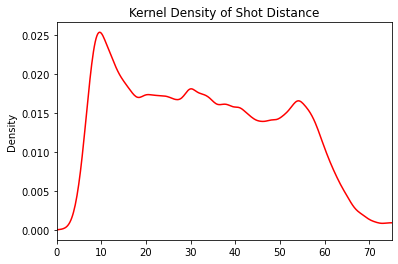

In [24]:
train_pd.shotDistance.plot.kde(bw_method = 1, xlim = [0, 75], title = "Kernel Density of Shot Distance", color = "red")

We can see there's a sharp drop-off at around 64 feet away from the goal, which is how far the blue line is from the goal. Anything within the blue line is in the offensive zone for the shooting team, and shots are not typically taken from past the blue line.

## Model Fitting

We will be fitting three different types of models to attempt to predict the probability of a goal being scored on a given shot.  We need to import several functions from the PySpark ML and MLLib libraries to set up the pipelines for each of these three models.

In [25]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, BinaryLogisticRegressionSummary, LogisticRegressionSummary, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.util import MLUtils
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

### Logistic Regression

The first model type we'll be testing to predict whether a goal is scored on a shot is a logistic regression model. This models the probability of an event (in this case, a goal being scored on a shot) occurring. The model is structured to predict the log odds (natural logarithm of the probability of the event occuring divided by the probability of the event not occurring) using a linear combination of the predictor variables. The predicted values can them be converted into the predicted probability of the event occurring. For this model, that probability is for a goal being scored on a given shot, more commonly known as "expected goals" in the hockey analytics world.

Some of the variables may have interactions with each other, so creating some transformations to add in those interaction terms for the shot type indicator variables is a good start. Wrap-around shots, specifically, may have an interesting interaction with shot distance because they are taken from much closer to the goal, on average, and are more difficult to convert. We also wanted to try including interactions between shot distance and slap shots or snap shots, because those were more common shot types and might have a different relationship with shot distance.

In [26]:
# interaction between shot type (slap shot) and shot distance
interaction_shotType_Slap_shotDistance = Interaction(inputCols = ["shotType_Slap", "shotDistance"], outputCol = "shotType_Slap_shotDistance")

In [27]:
# interaction between shot type (snap shot) and shot distance
interaction_shotType_Snap_shotDistance = Interaction(inputCols = ["shotType_Snap", "shotDistance"], outputCol = "shotType_Snap_shotDistance")

In [28]:
# interaction between shot type (wrist shot) and shot distance
interaction_shotType_Wrist_shotDistance = Interaction(inputCols = ["shotType_Wrist", "shotDistance"], outputCol = "shotType_Wrist_shotDistance")

In [29]:
# interaction between shot type (wraparound shot) and shot distance
interaction_shotType_Wrap_shotDistance = Interaction(inputCols = ["shotType_Wrap", "shotDistance"], outputCol = "shotType_Wrap_shotDistance")

Another transformation we tried was a log transformation on the shot distance. It stands to reason that the relationship between probability of a goal being scored and the shot distance is not completely linear. All else equal, the difference in goal probability on a shot 20 feet from the goal and one 30 feet from the goal may be different than the difference in goal probability on a shot 30 feet from goal and a shot 40 feet from the goal. The (natural) log transformation is a common transformation to help capture this relationship. 

In [30]:
# transformer to get the log of the shot distance
sqlTrans_log_shotDistance = SQLTransformer(
    statement = "SELECT *, log(shotDistance) as shotDistance_log FROM __THIS__"
)
# to test out the log transformation and see that it works as expected
sqlTrans_log_shotDistance.transform(nhl_spark).select(['shotDistance', 'shotDistance_log']).show(5)

+------------+------------------+
|shotDistance|  shotDistance_log|
+------------+------------------+
|   42.520584| 3.749988290595886|
|   30.610456| 3.421341665184415|
|     85.3815| 4.447129452552118|
|   29.274563|3.3767189763472905|
|   26.305893|3.2697929804091697|
+------------+------------------+
only showing top 5 rows



Next, we'll specify a list of the predictors to include in fitting the logistic regression model. We want to use a lot of the indicator variables created previously from our exploratory analysis, such as the indicators for different shot types and power play / penalty kill. The wrist shot indicator variable is excluded because that will be the reference category for shot type - predictions for wrist shots will simply not have any of the coefficients for the other shot type indicator variables applied to them.

In [31]:
# predictor variables to include in fitting logistic regression
lr_predictors_list = ['shotDistance_log', 'shotAngleAdjusted', 'powerPlay', 'penaltyKill', 'offWing', 'shotRush',
                      'shotType_Backhand', 'shotType_Deflection', 'shotType_Slap', 'shotType_Snap', 'shotType_Tip', 'shotType_Wrap',
                      'shotType_Slap_shotDistance', 'shotType_Snap_shotDistance', 'shotType_Wrap_shotDistance']

We need to set up a transformer to select the goal variable as label and then select all of the predictors from the provided Spark data frame.

In [32]:
# transformer to get set the response variable (goal) as label and select the predictor variables
sqlTrans_lr = SQLTransformer(
    statement = "SELECT goal as label, " + ", ".join(lr_predictors_list) + " FROM __THIS__"
)

The assembler will convert all of the predictors into a single column called "features".

In [33]:
# using wrist shots as the reference category for shot type
assembler_lr = VectorAssembler(inputCols = lr_predictors_list, outputCol = "features", handleInvalid = 'keep')

Below, we will specify our logistic regression model. There won't be any regularization applied to the predictor variables, though perhaps that's something work exploring down the road.

In [34]:
# fitting logistic regression model
lr1 = LogisticRegression(labelCol = "label", featuresCol = "features", regParam = 0, elasticNetParam = 0)

For our logistic regression model, the only parameters we are testing are whether or not to include an intercept in the model.

In [35]:
# set up the parameter grid for the logistic regression model to test model fits with and without an intercept
paramGrid_lr = (ParamGridBuilder() \
    .addGrid(lr1.regParam, [0]) \
    .addGrid(lr1.fitIntercept, [False, True]) \
    .addGrid(lr1.elasticNetParam, [0]) \
    .build())

Our pipeline needs to include all of the transformations to get interaction terms, log of shot distance, and get the data into the proper format for the Spark model fitting process.

In [36]:
# set up the pipeline for fitting the logistic regression model
pipeline = Pipeline(stages = [interaction_shotType_Slap_shotDistance, interaction_shotType_Snap_shotDistance, interaction_shotType_Wrap_shotDistance,
                              sqlTrans_log_shotDistance,
                              sqlTrans_lr, assembler_lr, lr1])

In [37]:
# specify cross-validation process for logistic regression model
crossval_lr = CrossValidator(estimator = pipeline,
                             estimatorParamMaps = paramGrid_lr,
                             evaluator = BinaryClassificationEvaluator(),
                             numFolds = 5)

Now it's time to fit the model on the training data set.

In [38]:
# Run cross-validation, and choose the best set of parameters.
cvModel_lr = crossval_lr.fit(train)

In [39]:
# get a list of the metric (AUC) for each of the part of the parameter grid
list(zip(cvModel_lr.avgMetrics, paramGrid_lr))

[(0.7323797544139359,
  {Param(parent='LogisticRegression_fff40c833d53', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_fff40c833d53', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_fff40c833d53', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.7373495278127897,
  {Param(parent='LogisticRegression_fff40c833d53', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_fff40c833d53', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_fff40c833d53', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

After finding the best fitting logistic regression model, we'd like to see the coefficients on each of the predictor variables.

In [40]:
# summary of coefficients in best fit logistic regression model
print(pd.DataFrame(lr_predictors_list, cvModel_lr.bestModel.stages[-1].coefficients.toArray().tolist(), columns = ['predictor_variable']))

                   predictor_variable
-1.221382            shotDistance_log
-0.013527           shotAngleAdjusted
 0.316553                   powerPlay
 0.023722                 penaltyKill
 0.084415                     offWing
 0.594163                    shotRush
-0.355639           shotType_Backhand
-0.465275         shotType_Deflection
 1.202895               shotType_Slap
 0.841032               shotType_Snap
-0.489753                shotType_Tip
-0.596169               shotType_Wrap
-0.020187  shotType_Slap_shotDistance
-0.011682  shotType_Snap_shotDistance
-0.151345  shotType_Wrap_shotDistance


In [41]:
print('The accuracy of the best fit logistic regression model is: ' + str(cvModel_lr.bestModel.stages[-1].summary.accuracy))
print('The AUC (area under ROC curve) of the best fit logistic regression model is: ' + str(cvModel_lr.bestModel.stages[-1].summary.areaUnderROC))

The accuracy of the best fit logistic regression model is: 0.9315527538155275
The AUC (area under ROC curve) of the best fit logistic regression model is: 0.7381701375614744


The accuracy shows the percent of correct predictions over total predictions. Our AUC is pretty high for a complicated problem like this.

Finally, we need to evaluate the best fit model on the test set using AUC, which will be our point of comparison to different model types.

In [42]:
# evaluate the model on the test set
test_auc = BinaryClassificationEvaluator().evaluate(cvModel_lr.transform(test))
print(test_auc)

0.7338475447169561


Looks like a promising start! Now let's try out some tree-based models.

### Classification Tree

We are going to fit a classification tree model on the training data next.  A classification tree model makes predictions based on splits.  A tree may have several splits, all based on specific values of different variables in the model.  The values for these splits are usually found by considering every possible value for every predictor, and choosing the one that minimizes a loss function or some kind of error, basically splitting at the "optimal" point for all possible splits.  This breaks the model up, and another split is found for each resulting side.  This continues until the model is really good at predicting the training set, but because the training set will not be exactly like other data sets, the model will not be good at predicting other data sets.  This is a result of the bias-variance trade off and is called "overfitting".  To counteract this, the user can restrict the depth of the model, or require a minimum of error reduction or observations for each split.  In this model, we will be cross-validating to find the optimal depth from a list of candidate values of depth.  It decides how many splits it should have based on ideas such as how much error a new split will resolve.  Once it has the final model, we can use it for prediction.

In PySpark, we fit a model with the `DecisionTreeClassifier()` function.  To fit a model on the training data, to predict the outcome of a shot as a goal or not, we need to set up a pipeline that will take care of the necessary transformations to fit the model in PySpark.  We start by creating our list of predictors and selecting the columns from that list and the response column "goal" as "label" in the `SQLTransformer()` function. I used mostly numeric variables here, but there are some indicator variables like offWing and shotAngleReboundRoyalRoad.

In [43]:
# List of predictors to include in the tree
treePredictorsList = ['defendingTeamAverageTimeOnIceOfDefencemen', 'defendingTeamAverageTimeOnIceOfForwards',
                      'shootingTeamAverageTimeOnIceOfDefencemen', 'shootingTeamAverageTimeOnIceOfForwards',
                      'distanceFromLastEvent', 'shooterTimeOnIce',
                      'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 
                      'shotRebound', 'shotRush', 'speedFromLastEvent',
                      'xCordAdjusted', 'yCordAdjusted', 
                      'powerPlay', 'penaltyKill', 'evenStrength', 'offWing',
                      'shotType_Backhand', 'shotType_Deflection', 'shotType_Slap', 
                      'shotType_Snap', 'shotType_Tip', 'shotType_Wrap', 'shotType_Wrist'] 
# Set up SQL transformer that selects "goal" (as label) and the predictors from the list
sqlTrans_tree = SQLTransformer(
    statement = "SELECT goal as label, " + ", ".join(treePredictorsList) + " FROM __THIS__"
)

The next step in the pipeline is to arrange the predictors into a vector using `VectorAssembler()`, it is important to name this column "features".

In [44]:
# Set up vector assembler for the predictors list, name this column "features"
assembler_tree = VectorAssembler(inputCols = treePredictorsList, outputCol = "features", handleInvalid = 'keep')

The last step in the pipeline is to pass these "label" (goal) and "features" (predictors) to the `DecisionTreeClassifier()` function, which will fit the model.  We can specify these three stages in our pipeline using `Pipeline()`, then save it as "pipeline_tree".

In [45]:
# Classification Tree function with label and features arguments
ct = DecisionTreeClassifier(labelCol = "label", featuresCol = "features")
# Set up pipeline with its 3 stages
pipeline_tree = Pipeline(stages = [sqlTrans_tree, assembler_tree, ct])

We want to also try different values for the tuning parameter "maxDepth" for the classification tree.  "maxDepth" is the maximum depth of tree allowed, which can be anywhere from 1 to 30.  Think of depth as the different levels that result from splits in the model.  To keep computation time somewhat lower, we are going to try 4, 6, 8, and 10 maximum levels of depth in our model.  We can choose the best value from these by performing 5-fold cross validation.  This is done in the `CrossValidator()` function, and takes in the pipeline and grid of parameters to try then evaluates them using `BinaryClassificationEvaluator()`.  Once this is set up, we can fit a cross-validated classification tree model on the training data with the `.fit()` method.

In [46]:
# Set up the grid of tuning parameters to try, try different values for max depth
paramGrid_tree = ParamGridBuilder() \
    .addGrid(ct.maxDepth, [4, 6, 8, 10]) \
    .build()
# Set up 5 fold cross validation for the classification tree pipeline, evaluate each model using BinaryClassificationEvaluator
crossval_tree = CrossValidator(estimator = pipeline_tree,
                          estimatorParamMaps = paramGrid_tree,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [47]:
# Fit the cross-validated classification tree
cvModel_tree = crossval_tree.fit(train)

Now that our model is fit, we can compare the models for each level of "maxDepth" to see which value was the best.  The default measure for this is the AUC ROC.  To find this, we need to access the "avgMetrics" attribute of our cross validated model.

In [48]:
# List out all max depths their corresponding AUC ROC
list(zip(cvModel_tree.avgMetrics, paramGrid_tree))

[(0.5,
  {Param(parent='DecisionTreeClassifier_f84c5aa8a611', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4}),
 (0.6043988580342095,
  {Param(parent='DecisionTreeClassifier_f84c5aa8a611', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6}),
 (0.6196311883409351,
  {Param(parent='DecisionTreeClassifier_f84c5aa8a611', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 8}),
 (0.6105153546542373,
  {Param(parent='DecisionTreeClassifier_f84c5aa8a611', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10})]

It appears that the best value of "maxDepth" to use of the ones we supplied was 8.  This model had an AUC of about 0.61 on the training data.  Just to be sure, we can look print out the max depth value with the `.getMaxDepth()` method and get the AUC from the `.evaluate` method.

In [49]:
# Print the values of max depth and min instances per node that give us the best classification tree model
print(cvModel_tree.bestModel.stages[-1]._java_obj.getMaxDepth())

8


In [50]:
# Print AUC
train_error = BinaryClassificationEvaluator().evaluate(cvModel_tree.transform(train))
print(train_error)

0.6134122189882364


Another output we can look at to help understand our model is the "feature importance" of each of our predictors.  This essentially estimates the proportion of the variability in our training data explained by each predictor.  We can do this by accessing the `.featureImportances` attribute of the `.bestModel` attribute of our cross validated model.

In [51]:
# Print importances by zipping together the predictor list with the featureImportances attribute of the best model
ps.DataFrame(list(zip(treePredictorsList, list(cvModel_tree.bestModel.stages[-1].featureImportances))), 
             columns = ["feature", "importance"]).sort_values(by = ["importance"], ascending = [False])

,feature,importance
11,xCordAdjusted,0.346224
12,yCordAdjusted,0.191964
8,shotRebound,0.169827
10,speedFromLastEvent,0.048412
7,shotAnglePlusReboundSpeed,0.033026
1,defendingTeamAverageTimeOnIceOfForwards,0.032900
4,distanceFromLastEvent,0.032695
0,defendingTeamAverageTimeOnIceOfDefencemen,0.028797
2,shootingTeamAverageTimeOnIceOfDefencemen,0.027294
6,shotAnglePlusRebound,0.022406


It appears that xCordAdjusted, yCordAdjusted, and shotRebound are super important, which makes sense intuitively.  The X and Y coordinates determine how far the shooter is from the goal, and goals are much more likely to go in if they are a rebound.  It looks like shotRush, evenStrength, and shotType_Wrap had minuscule prediction power.  This may be because so many shots are taken at evenStrength, it's hard to say what its effect is.  Wraparounds rarely happen in the league and rarely go in, and shotRush is kind of an odd term since it is hard to define what is clearly a rush in hockey.

Lastly, it is important that we evaluate the model on the testing data.  To do this, we use the `.evaluate()` method.

In [52]:
# Print out the testing set error of the best classification tree model that we had
test_error = BinaryClassificationEvaluator().evaluate(cvModel_tree.transform(test))
print(test_error)

0.6196515704197392


It looks like the model had an AUC of about .612 on the testing data, which is lower than our logistic regression model.

### Random Forest

Next, we will try fitting a Random Forest model to predict the probability of a goal being scored on a shot. The Random Forest algorithm is another tree-based model fitting algorithm that creates multiple classification trees (the number as specified in the function) and averages predictions across those trees. Each of the trees are made up of splits along different variables - for example, splitting on shooter time on ice less than 30 seconds or greater than or equal to 30 seconds. Down each path of splits within a tree, there can be a maximum number of splits as defined by the parameter maxDepth in the function. The parameter minInstancesPerNode puts a lower limit on the number of observations that can be included in one of the nodes at the end of a given tree path. A very low value of minInstancesPerNode can lead to overfitting on the training set and also ramps up the computational time significantly. Each tree is fit using a subset of the predictor variables, which helps to reduce the chance that a few strong variables dominate all of the trees fit within the algorithm. The random forest model is good at capturing non-linear relationships between predictor variables and the response variable, as well as interactions between different predictor variables (those show up as splits within the trees). The prediction comes from whichever node (terminal point of the tree) the observation falls in based on its predictor variable values for each of the trees and averages those predicted values. 

We'll be including more of the possible predictor variables in the random forest. More notably, we excluded shot angle and shot distance from the random forest because those are highly correlated with xCordAdjusted and yCordAdjusted (they are really functions of the x-coordinate and y-coordinate relative to the position of the goal). The x-coordinate and y-coordinate adjusted variables can be used for different splits to capture the non-linear relationship between those and whether the shot is scored (goal variable). For example, shot with an x-coordinate that corresponds to a shot from behind the net is a high x-coordinate value, but a low likelihood of being scored. The Random Forest can help capture some of the relationship between offWing (an indicator of whether the shooter is shooting on the opposite side of the ice as their handedness, for example a right-shot player shooting from the left side of the goal) and the x-coordinate and y-coordinate.

In [53]:
# predictors to include in random forest
rf_predictors_list = ['defendingTeamAverageTimeOnIceOfDefencemen', 'defendingTeamAverageTimeOnIceOfForwards',
                      'shootingTeamAverageTimeOnIceOfDefencemen', 'shootingTeamAverageTimeOnIceOfForwards',
                      'distanceFromLastEvent', 'shooterTimeOnIce',
                      'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 
                      'shotRebound', 'shotRush', 'speedFromLastEvent',
                      'xCordAdjusted', 'yCordAdjusted', 
                      'powerPlay', 'penaltyKill', 'evenStrength', 'offWing',
                      'shotType_Backhand', 'shotType_Deflection', 'shotType_Slap', 
                      'shotType_Snap', 'shotType_Tip', 'shotType_Wrap', 'shotType_Wrist']

First, we need to set up a Spark transformer to get the data into a format with the response variable as label and the predictors specified.

In [54]:
# select label and feature variables for Random Forest
sqlTrans_rf = SQLTransformer(
    statement = "SELECT goal as label, " + ", ".join(rf_predictors_list) + " FROM __THIS__"
)

The assembler will put all of the predictors into one vector with all of the predictor values.

In [55]:
# predictors to include in Random Forest
assembler_rf = VectorAssembler(inputCols = rf_predictors_list, 
                               outputCol = "features", handleInvalid = 'keep')

# look at 10 rows of the data with this transformation applied to them
assembler_rf.transform(sqlTrans_rf.transform(train)).select("label", "features").show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(24,[0,1,2,3,4,5,...|
|    0|(24,[0,1,2,3,4,5,...|
|    0|(24,[0,1,2,3,4,5,...|
|    1|[77.0,35.66666793...|
|    0|(24,[0,1,2,3,4,5,...|
|    1|(24,[0,1,2,3,4,5,...|
|    0|(24,[0,1,2,3,4,5,...|
|    1|(24,[0,1,2,3,4,5,...|
|    0|(24,[0,1,2,3,4,5,...|
|    1|(24,[0,1,2,3,4,5,...|
+-----+--------------------+
only showing top 10 rows



Now we need to define the Random Forest model. We'll set a seed to allow repeatability in the model fitting process. The number of trees specifies the number of different trees fit in the random forest, which eventually are averaged to generate the predictions.

In [56]:
# define the random forest classifier with the number of trees to fit and set a seed for ability to replicate the analysis
rf1 = RandomForestClassifier(featuresCol = "features", labelCol = "label", seed = 19, numTrees = 100)

Next, we want to test out some of the different parameters for the random forest model to attempt to find close to the best set of parameters. The max depth refers to the number of different splits allowed down one branch of a tree. The minimum instances per node is the minimum observations from the data set allowed in the terminal node of a tree. A lower minimum instances per node can get closer to the fit of the training set of data, but that runs the risk of overfitting the model on the training set. We decided to use a minimum of 50 instances per node to balance allowing the random forest to find smaller segments of shots with different interactions with the concern that too small of a minimum instances per node would lead to over-fitting on the training data set. Given there are many predictors, we'd like to consider a higher maximum depth, but the computational intensity of those trees being fit grows quickly. We decided to balance that out so that the computer could handle the highest maximum depth value in the parameter grid, though theoretically we could test out a larger parameter grid if we had access to more computing power.

In [57]:
# set up the parameter grid to test out different maxDepth and minInstancesPerNode values in the Random Forest cross-validation process
paramGrid_rf = (ParamGridBuilder() \
    .addGrid(rf1.maxDepth, [6, 8, 10]) \
    .addGrid(rf1.minInstancesPerNode, [50, 100, 200]) \
    .build())

We'll be defining the evaluator using the area under the ROC curve, the default evaluator for a binary classification model and the same one used for evaluating the logistic regression and classification tree models. The label column for the response variable is specified based on the random forest model above.

In [58]:
# define the evaluator with the metric and label column for this random forest model
evaluator_rf = BinaryClassificationEvaluator(metricName = "areaUnderROC", labelCol = rf1.getLabelCol())

Finally, our pipeline is specified to follow all those transformations before the model fitting process defined above.

In [59]:
# set up the pipeline for fitting the random forest model
pipeline_rf = Pipeline(stages = [sqlTrans_rf, assembler_rf, rf1])

Now, it's time to set up the cross-validation based on the random forest pipeline and the different parameter values we specified to test out.

In [60]:
# perform cross validation by fitting different Random Forest models using the specified model pipeline and...
## different parameter values to test in the parameter grid
cv_rf = CrossValidator(estimator = pipeline_rf,
                       estimatorParamMaps = paramGrid_rf,
                       evaluator = evaluator_rf,
                       numFolds = 5)

Now that we have the cross-validation process set up with the random forest model pipeline and the different parameters in the parameter grid to test out, we will use the training data set to fit different models in the cross-validation process and find the best fit.

In [61]:
# Run cross-validation on the training set and choose the best set of parameters for the random forest model
cv_model_rf = cv_rf.fit(train)

To get the best fit model from the cross-validation process, we need to select that object from the stages of the pipeline specified above.

In [62]:
# best model fit from random forest cross validation
bestModel_rf_cv = cv_model_rf.bestModel.stages[-1]

Based on that best fit model, we want to see the parameters to come out of that cross-validation process.

In [63]:
print('numTrees - ', bestModel_rf_cv.getNumTrees)
print('maxDepth - ', bestModel_rf_cv.getOrDefault('maxDepth'))
print('minInstancesPerNode - ', bestModel_rf_cv.getOrDefault('minInstancesPerNode'))

numTrees -  100
maxDepth -  10
minInstancesPerNode -  50


Now, we want to see which of the features (predictors) were most important in the random forest model. The default feature importance calculation looks at the average improvement on misclassification rate (predicting the incorrect outcome) of splits using that feature.

In [64]:
# get feature importances from best fit random forest model
## sort them by importance in descending order
ps.DataFrame(list(zip(rf_predictors_list, list(bestModel_rf_cv.featureImportances))), columns = ["feature", "importance"]).sort_values(by = ["importance"], ascending = [False])

,feature,importance
8,shotRebound,0.255114
11,xCordAdjusted,0.245764
7,shotAnglePlusReboundSpeed,0.186932
12,yCordAdjusted,0.114388
10,speedFromLastEvent,0.045703
4,distanceFromLastEvent,0.034232
6,shotAnglePlusRebound,0.028827
13,powerPlay,0.015069
15,evenStrength,0.014426
5,shooterTimeOnIce,0.011992


We can see that the xCordAdjusted and yCordAdjusted variables are very important in fitting the trees within the random forest model, which is not surprising. shotAnglePlusReboundSpeed, which is the angle between this shot and the previous shot divided by the the time between those two events (essentially, how fast the angle changed as per the documentation), shows up as very important. This makes sense too, because a shot off a rebound coming from the opposite side of the goal generally means a quick shift of direction that is very difficult for the goalie to cover. Seeing shotRebound being important indicates that whether a shot is off a rebound is a fairly strong predictor of whether it is scored. Another interesting set of variables is speedFromLastEvent and distanceFromLastEvent - perhaps a shot that takes place far from where the last event recorded in the play-by-play data occurred, especially if it was shortly after that event, indicates a rapid change in possession and a quick transition to offense. We didn't gain a ton from the indicator variables for power play, even strength, penalty kill, or the shot types, but they at least showed up in some splits within the trees.

Now, we need to use the best fit random forest model to make predictions on the test set of data. The predictions on data not used in fitting the model can provide a better picture of the effectiveness of the model and a point of comparison against the different model types.

In [65]:
# evaluating the random forest on the test (holdout) data set
rf_predictions_test = cv_model_rf.transform(test)

Using those predictions on the test set of data, we will evaluate the effectiveness of the model based on the AUC.

In [66]:
evaluator_rf.evaluate(rf_predictions_test)

0.7076231319390369

The AUC of the random forest predictions on the test set is still pretty high for a complex outcome to model, but not as high as that of the logistic regression model on the test set. Perhaps with greater computing power, we could further tune a random forest model with higher maximum depth, but this at least shows some of the variables that are important and has solid predictive ability.

## Conclusion

All in all, it appears that currently our best model is the logistic regression model.  We found that specifying many combinations of tuning parameters on the tree-based models was computationally expensive, even for Spark.  This data set has many predictors and over 100,000 observations, so fitting something like a random forest takes a long time for a single personal computer. Perhaps in the future, it would be interesting to try to fit a random forest model using a more powerful computer to better optimize the parameters and allow for deeper trees. The AUC values for the random forest and logistic regression were above 0.70, which is pretty good considering how unpredictable something like an NHL shot going in the goal is.  The classification tree did not do all that well, however.  We were able to find that distance, rebounds, and rebound speed were big indicators of whether or not a goal goes in.  Perhaps these are obvious, but in a future analysis perhaps we can try to isolate these variables a little bit better and see what the next most important variables are. 